In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import numpy as np

def check_global_local(features, imagepairDetails):
    nL = 37
    N = len(features)
    g1 = imagepairDetails[:, 0]
    l1 = imagepairDetails[:, 1]
    g2 = imagepairDetails[:, 2]
    l2 = imagepairDetails[:, 3]

    indexG = np.where(l1 == l2)[0]
    indexL = np.where(g1 == g2)[0]

    layerwiseDist = np.zeros((len(indexG), nL))
    mean_global_distance = np.zeros(nL)
    mean_local_distance = np.zeros(nL)

    for Layer in range(nL):
        temp = features[0][Layer].x
        fl = len(temp.ravel())
        layerF = np.zeros((fl, N))
        for ind_img in range(N):
            layerF[:, ind_img] = features[ind_img][Layer].x.ravel()
        
        layerwiseDist[:, Layer] = np.linalg.norm(layerF[indexG, :] - layerF[indexG, :].mean(axis=1, keepdims=True), axis=1)
        mean_global_distance[Layer] = np.nanmean(layerwiseDist[:, Layer])

        layerwiseDist[:, Layer] = np.linalg.norm(layerF[indexL, :] - layerF[indexL, :].mean(axis=1, keepdims=True), axis=1)
        mean_local_distance[Layer] = np.nanmean(layerwiseDist[:, Layer])

    mi_global_local = (mean_global_distance - mean_local_distance) / (mean_global_distance + mean_local_distance)
    
    return mi_global_local


In [16]:
import torch
import torch.nn.functional as F
import torch.nn as nn

def vl_simplenn(net, x, res=None):
    n=len(net.features) + len(net.classifier)
    if (res is None):
        res = [{'x': None} for _ in range(n + 1)]

    res[0]['x'] = x
    i=0
    for (name, layer) in net.named_children():
        
        for  (sub_name, sub_layer) in (layer.named_children()):
            ltype=sub_layer.__class__.__name__
            if ltype == 'Conv2d':
                res[i + 1]['x'] = F.conv2d(res[i]['x'], sub_layer.weight,sub_layer.bias,
                            padding=sub_layer.padding, stride=sub_layer.stride, dilation=sub_layer.dilation)

            elif ltype == 'MaxPool2d':
                res[i + 1]['x'] = F.max_pool2d(res[i]['x'],
                            padding=sub_layer.padding, stride=sub_layer.stride,kernel_size=sub_layer.kernel_size)
            elif ltype=='Linear':
                linear_layer = nn.Linear(res[i]['x'].flatten().shape[0], 4096)
                output_tensor = linear_layer(res[i]['x'].flatten())
                res[i + 1]['x'] = output_tensor.to(torch.float32)
            elif ltype=='Dropout':
                i=i-1
            elif ltype== 'ReLU':
                leak = {}

                if res[i]['x'] is not None:
                    res[i + 1]['x'] = F.relu(res[i]['x'], **leak)
                else:
                    res[i + 1]['x'] = F.relu(res[i + 1]['x'], **leak)
            i+=1



    return res


In [21]:
import torch
import torchvision.transforms as transforms
from torchvision.models import vgg16
from PIL import Image
import numpy as np

def extract_features(stim_data, types, dagg_flag):
    # Load the VGG16 model
    model1 = vgg16(pretrained=True)
    model1.eval()  # Set the model to evaluation mode
    model2=vgg16(pretrained=False)
    model2.eval()
    # Define the preprocessing transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Extract the image data from the loaded dictionary
    # stim_images = stim_data['stim'][0]
#     print(stim_data['stim'])

    nimages =  len(stim_data)
    if dagg_flag==0:
        features1= []
        features2=[]
        i=0
        for ind in range(nimages):
            print("Image:",ind)
            # Convert the numpy array to PIL Image
            image_array = stim_data[ind][0]
            if len(image_array.shape) < 3:
                image_array = np.stack((image_array,) * 3, axis=-1)
            image = Image.fromarray(image_array)

        # Preprocess and normalize the image
            image_tensor = preprocess(image).unsqueeze(0)
                # Perform inference using the model
#             with torch.no_grad():
#                 output = model(image_tensor)

            # Append the features to the list
            features1.append(vl_simplenn(model1, image_tensor))
            features2.append(vl_simplenn(model2, image_tensor))
#             if ind%4==3:
#                 print('Calculating Check_RelSize_Effect of 4 images')
#                 check_relsize_effect(features)
#                 i=i+1
#                 features=[]
        return features1,features2


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.io





# Networks
# network_types = ['imagenet-vgg-verydeep-16', 'imagenet-matconvnet-vgg-verydeep-16.mat', 'imagenet-vgg-verydeep-16_randn.mat',
#                 'imagenet-vgg-face', 'imagenet-caffe-alex', 'imagenet-googlenet-dag', 'imagenet-resnet-50-dag', 'imagenet-resnet-152-dag']
# dagg_flags = [0, 0, 0, 0, 0, 0, 1, 1]
# network_short_names = ['VGG-16', 'mat.VGG-16', 'VGG-16 randn', 'VGG-face', 'Alexnet', 'Goolgenet', 'ResNet 50', 'ResNet 152']
network_types = ['/kaggle/input/resnet50/other/2/1/imagenet-vgg-verydeep-16.mat']
dagg_flags = [0]
network_short_names = ['VGG-face']

# STIM
stim_file_name = '/kaggle/input/globallocal/GL.mat'
stim_data = scipy.io.loadmat(stim_file_name)
stim = stim_data['stim']

 # Load image pair details
imgae_file= '/kaggle/input/globallocal/L2_VSmain.mat'
L2_str = scipy.io.loadmat(imgae_file)
imagepairDetails = L2_str['L2_str'][0][0]['Image_Pair_Details']


# Behavior effect Calculation
reference_mi = 0.0975
reference_name = 'Jacob and Arun, 2019'
y_label_name = 'Global Advantage Index'
dist_types = 'Euclidean'

miglobal_local=[]

features1,features2 = extract_features(stim, 'net_type',0)

# Global Local
miglobal_local.append(check_global_local(features1, imagepairDetails))
miglobal_local.append(check_global_local(features2, imagepairDetails))







/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Image: 0
Image: 1
Image: 2
Image: 3
Image: 4
Image: 5
Image: 6
Image: 7
Image: 8
Image: 9
Image: 10
Image: 11
Image: 12
Image: 13
Image: 14
Image: 15
Image: 16
Image: 17
Image: 18
Image: 19
Image: 20
Image: 21


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D


def layerwise_mi_figures(mean_data, sem_data, file_name, reference_mi=None, reference_name=None, legend_name=None,
                         y_label=None, shaded_region_name='Human perception', y_limits=None):
    if y_limits is None:
        y_limits = [-1, 1]

    plt.figure(figsize=(7, 4))

    # Drawing the human perception rectangle
    plt.gca().add_patch(Rectangle((1, 0), 37, 1, facecolor=[0.8, 0.8, 0.8], edgecolor='none'))

    # Naming the layers by drawing the bottom rectangles
    layer_grouping = np.array([[1, 6.45], [6.55, 11.45], [11.55, 18.45], [18.55, 25.45], [25.55, 32.45], [32.55, 37]])
    layer_colour = np.vstack([np.tile([0.8, 0.8, 0.8], (5, 1)), [0.5, 0.5, 0.5]])
    box_width = 0.2 / (y_limits[1] - y_limits[0])

    for ind, (start, end) in enumerate(layer_grouping):
        plt.gca().add_patch(
            Rectangle((start, y_limits[0]), end - start, box_width, facecolor=layer_colour[ind], edgecolor='none'))
        plt.text(start + 0.4, y_limits[0] + box_width / 2, ['conv-1', 'conv-2', 'conv-3', 'conv-4', 'conv-5', 'fc'][ind], color='k', fontsize=6)

    # Plotting the data
    line_colour = plt.cm.get_cmap('tab10')
    marker_size = 2
    layer_ind = np.arange(1, 38)
    # print(mean_data)
    # print(np.array(mean_data).shape)
    mean_data = np.array(mean_data)
    for ind in range(mean_data.shape[0]):
        if sem_data is not None and not np.all(np.isnan(sem_data)):
            shadedErrorBar(layer_ind, mean_data[ind], sem_data[ind], lineprops=['-', {'markerfacecolor': line_colour(ind), 'color': line_colour(ind), 'linewidth': 0.5}], transparent=True, patchSaturation=0.3)
        else:
            plt.plot(layer_ind, mean_data[ind], '-', markerfacecolor=line_colour(ind), color=line_colour(ind), linewidth=0.5)

        plt.plot(layer_ind[1:14:2], mean_data[ind, 1:14:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind))
        plt.plot(layer_ind[2:15:2], mean_data[ind, 2:15:2], 'o', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[5:16:3], mean_data[ind, 5:16:3], 'd', markersize=marker_size,
                 markeredgecolor=line_colour(ind), markerfacecolor=line_colour(ind))
        plt.plot(layer_ind[32:], mean_data[ind, 32:], 's', markersize=marker_size, markeredgecolor=line_colour(ind))

    # Visual search modulation index
    if reference_mi is not None:
        if isinstance(reference_mi, (list, np.ndarray)):
            for i, mi in enumerate(reference_mi):
                plt.plot([1, 37], [mi, mi], '--', color='k', linewidth=0.5)
                plt.text(2, mi + 0.1, reference_name[i], fontsize=6)
        else:
            plt.plot([1, 37], [reference_mi, reference_mi], '--', color='k', linewidth=0.5)
            plt.text(2, reference_mi + 0.1, reference_name, fontsize=6)

    # Naming the shaded region
    plt.text(3, 0.9, shaded_region_name, fontsize=6)

    plt.xlim(0.5, 37.5)
    plt.ylim(y_limits)
    plt.xticks(range(1, 38))
    plt.yticks(np.linspace(y_limits[0], y_limits[1], 5))

    plt.xlabel('VGG-16 layers')
    plt.ylabel(y_label)

    if legend_name is not None:
        handles, labels = plt.gca().get_legend_handles_labels()
        plt.legend(handles, labels, fontsize=6, loc='best', bbox_to_anchor=(1, 1), frameon=False)

    plt.tight_layout()
  #  plt.savefig(file_name + '.pdf')
    plt.show()

/tmp/ipykernel_382/1456367342.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  line_colour = plt.cm.get_cmap('tab10')


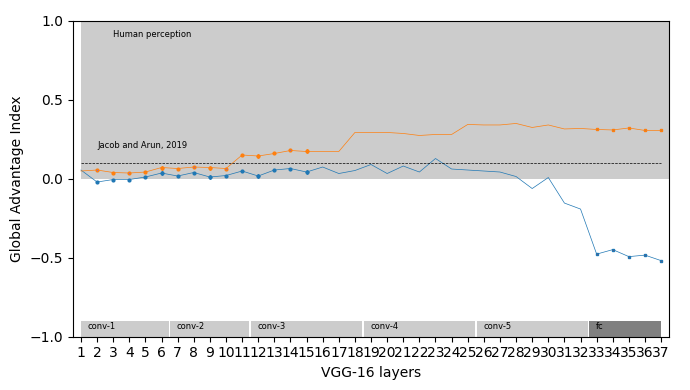

In [5]:
reference_mi=0.0975;
reference_name='Jacob and Arun, 2019';
y_label='Global Advantage Index';
dist_types='Euclidean';

# layerwise_mi_figures(mi_global_local,[],'file_name_pdf',reference_mi,reference_name,dist_types,y_label_name);
layerwise_mi_figures(mi_global_local, [], 'file_name', reference_mi, reference_name, ['VGG16,VGG16_rand'], y_label)